<a href="https://colab.research.google.com/github/Ulises-Diaz/pytorch_projects-/blob/main/FlowMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook you will learn how to implement a Flow Matching Algorithm to create Animals, Note that you could change the Dataset and create different objects.

To see explanations, mathematical derivations, see the drive link for lectures summaries

This is aswell Part of the project presented at ICRA 2026, made by @eduardoHernandez and @UlisesDiaz.

Each section will have a Mathematical Explation, the goal is to make it easier to understand. Thus, it will have several animations to make you understand

Note that this is animations and the mathematical explanation is not on the official Code.

We make this to help the community into this topic.

It is important to note that most of it, comes from : where, they explain each detail, so go and see it.


Hope you like it.


## 1. Install Dependencies

1.- Torch, torchvision, torchaudio,
2.- matplotlib , numpy, tqdm, pillow
3.- gdown
4.- einops

In [29]:
!pip install torch torchvision torchaudio
!pip install matplotlib numpy tqdm pillow
!pip install gdown # for dataset download
!pip install einops  #for tensor manipulation

## 2. Initial Configuration

Standard Pytorch configurations


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from typing import Tuple, Optional
import math
import einops

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Usando dispositivo: cuda


## 3. Download and Prepare Dataset

Note that you can change for any dataset you want, the code should work the same

Download the dataset in: https://www.dropbox.com/scl/fi/kpxh6hu04eu28yb8l30wy/afhq.zip?e=2&rlkey=usjnva71u164xd4rq6ghlab1u&dl=0


In [31]:
import gdown
import zipfile

def download_ahfq_datset():
  urls = {
      'train' : '/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/train',
      'val' : '/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/val'
  }

  os.makedirs('data', exist_ok=True)

  for split, url in urls.items():
    output_path = f'data/afhq_{split}.zip'
    if not os.path.exists(output_path):
      print(f"Descargando {split} set ...")
      gdown.download(url, output_path, quiet=False)

      #extraer data
      with zipfile.ZipFile(output_path, 'r') as zip_ref :
        zip_ref.extractall('data/')
      print(f"{split} set descargado y extraido")



## 4. Using the Dataset

Here,  we sample and get the transforms of the Dataset Above

Dataset cargado: 7813 imágenes
Dimensiones de imagen: 64x64


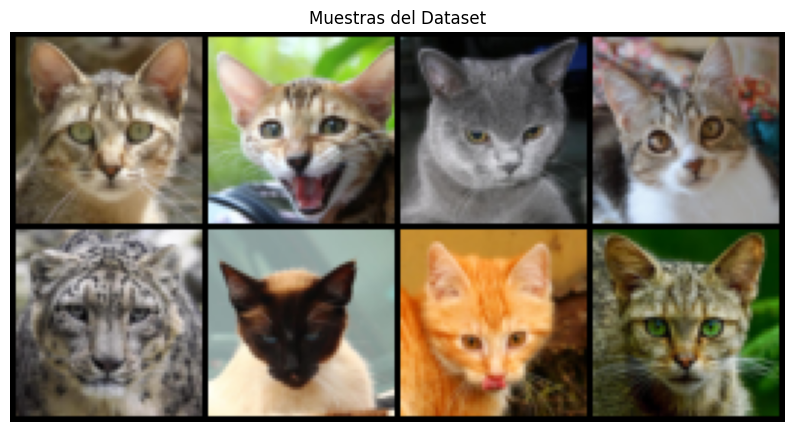

In [32]:
def get_transforms(image_size=64):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
    ])

# Crear dataset personalizado
class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        # Buscar todas las imágenes en subdirectorios
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(root, file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Configurar datasets y dataloaders
IMAGE_SIZE = 64
BATCH_SIZE = 32 # Number of images per sample

transform = get_transforms(IMAGE_SIZE)

train_dataset = AnimalDataset('/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/train', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print(f"Dataset cargado: {len(train_dataset)} imágenes")
print(f"Dimensiones de imagen: {IMAGE_SIZE}x{IMAGE_SIZE}")

# Visualizar algunas imágenes del dataset
def show_samples(loader, num_samples=8):
    batch = next(iter(loader))
    images = batch[:num_samples]

    # Desnormalizar para visualización
    images = (images + 1) / 2

    grid = make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Muestras del Dataset")
    plt.axis('off')
    plt.show()

show_samples(train_loader)

# 5. Initial Gaussian Distribution

Here we start seeing actual stuff on Flow Matching.

Fist, we need a classs to manage the sampling of Gaussian Distribution x0 , we start from pure noise (Gaussian Distribution) to real data (images)


To see the explanation of Flow Matching and the Notes of the paper, see `section 0`

The explanation of this Part is in Lecture 1. Go and see it.




forma del ruido : torch.Size([16, 3, 64, 64])
Rango valores : [-4.537, 4.189]
Media : -0.004, Std: 0.999
Forma de log_probs : torch.Size([16])


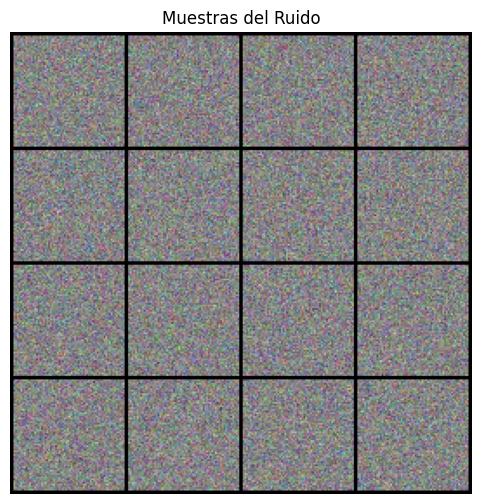

In [33]:
import torch
import numpy as np
from typing import Tuple
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Definir variables de ejemplo para que el código sea ejecutable
IMAGE_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SAMPLIGN
class GaussianNoiseSource  :
  '''
  Clase para manejar el muestreo de la distribucion Gaussaiana inicial x_0
  Para Flow Matching, iniciamos desde ruido puro y "fluimos" hacia datos reales
  '''
  def __init__(self, shape:Tuple[int, ...], device : str = 'cpu'): # Almacena la forma de los tensores de la imagen para CALCULAR D
    '''
    Argumentos :
      shape : Forma de las Imagenes, en este caso, (Channel, Height , Width)
      device : Dispositivo para generar muestras
    '''
    self.shape = shape
    self.device = device


  def sample (self, batch_size : int) -> torch.Tensor :
    # Shows Initial Gaussian Distribution x_0 , N(0, I), explicar que es esto
    # Need a Batch size and Returns Tensor Shape
    # Sampling Function. GEnerates a Tensor of random numbers that follow a Gaussian Distribution (mean 0, std 1)
    # Tensor size of (batch_size, Channles, Height, Width)
    return torch.randn(batch_size, *self.shape, device = self.device)

  def log_prob (self, x: torch.Tensor) -> torch.Tensor:
    '''
    Calcula log px(x) para x ~ N (0 , I)
    Args :
      x : Tensor de Muestras
    Returns :
      Log-likelihood shape (batch_size)
    '''
    # Log-likelihood gaussian
    dim = torch.prod(torch.tensor(self.shape, device = x.device)) # Calculates total dimension D of vecotr.


    # Formula Explained in Lecture notes
    log_prob = -0.5 * dim * torch.log(torch.tensor(2 * np.pi , device = x.device)) - 0.5 * x.pow(2).sum(dim=(1, 2, 3)) #x.pow ... is the sum of squares from all elements image

    return log_prob

# Generar Ruido
noise_source = GaussianNoiseSource(shape=(3, IMAGE_SIZE, IMAGE_SIZE), device = device)

def gaussian_sampling():
  noise_samples = noise_source.sample(16)

  # calcular log-likelihood
  log_probs = noise_source.log_prob(noise_samples)

  print(f'forma del ruido : {noise_samples.shape}')
  print(f'Rango valores : [{noise_samples.min():.3f}, {noise_samples.max():.3f}]')
  print(f'Media : {noise_samples.mean():.3f}, Std: {noise_samples.std():.3f}')
  print(f'Forma de log_probs : {log_probs.shape}')

  # Visualize noise
  noise_grid = make_grid(noise_samples.cpu(), nrow = 4 , padding=2, normalize = True)
  plt.figure(figsize=(10, 6))
  plt.imshow(noise_grid.permute(1, 2, 0))
  plt.title('Muestras del Ruido')
  plt.axis('off')
  plt.show()

gaussian_sampling()

## Conditional Vector Field

This section is where the Generative model start. As seen in the notes, the vector field is how the Gaussian Distribution is transported to the real distribution. See  Lecture X for more details




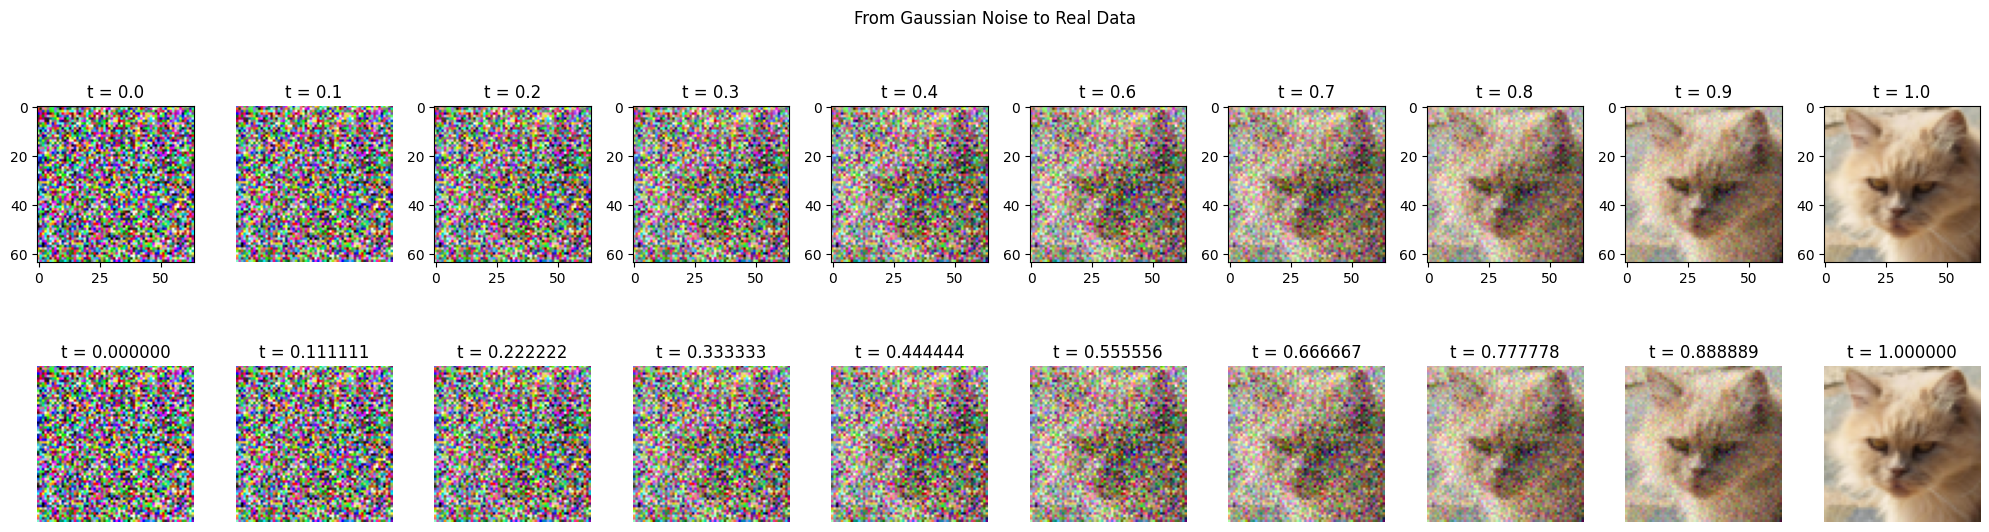

=== Propiedades del Campo Vectorial Condicional ===
Forma del campo vectorial: torch.Size([4, 3, 64, 64])
Magnitud promedio: 121.0061
Magnitud std: 3.2644
Magnitud min/max: 117.1143/125.1051


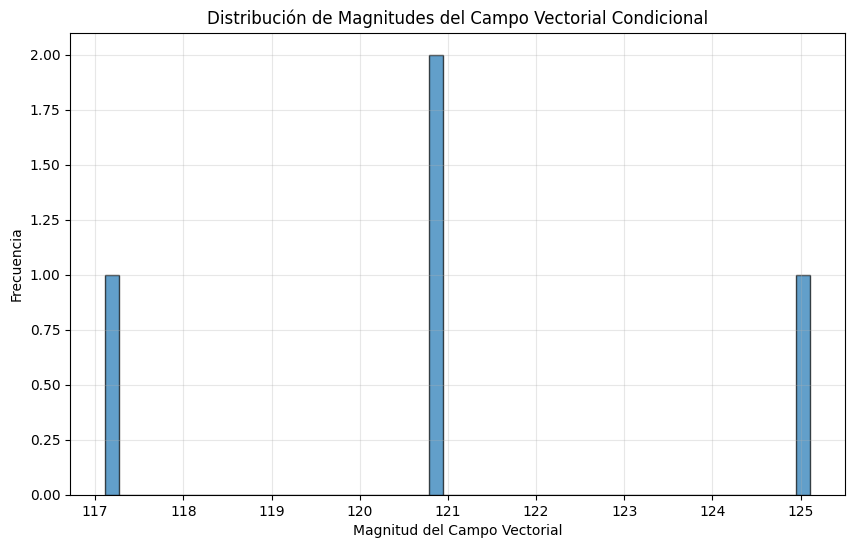


=== Ejemplo en t=0.5 ===
Punto interpolado x_t forma: torch.Size([1, 3, 64, 64])
Campo vectorial forma: torch.Size([1, 3, 64, 64])
Norma del campo vectorial: 120.8920


In [34]:
def create_condition_vector_field(x0: torch.Tensor , x1 : torch.Tensor , t: torch.Tensor)-> torch.Tensor:

  '''

  Create Vector Field.

  For Flow Matching, the Optimal Path is a straight line from x0 to x1 :
  ψ_t(x) = (1-t)x_0 + t*x_1


  Thus, Conditional Vector Field is :
  u_t(x|x_0,x_1) = d/dt ψ_t(x) = x_1 - x_0


  where :
  x0 : Initial Distribution (Gaussian Noise) of shape (Batch_size, Channels, Height, Width)
  x1 : Final Distribution (real data) of shape (Batch_size, Channels, Height, Widht)
  t  : Time Shape (batch_size, 1, 1, 1 ) o (batch_size , )

  Returns :
    Conditional vector field in shape (batch_size, channels, Height, Width)

  '''

  # Vector Field is x1- x0


  conditional_vf = x1 - x0
  return conditional_vf


def interpolate_path (x0: torch.Tensor, x1: torch.Tensor, t: torch.Tensor) :
  '''

  Calculate the Optimal Path ψ_t(x) = (1-t)x_0 + t*x_1


    Args:
        x0: Puntos iniciales de forma (batch_size, C, H, W)
        x1: Puntos finales de forma (batch_size, C, H, W)
        t: Tiempo de forma (batch_size, 1, 1, 1)

    Returns:
        Puntos interpolados de forma (batch_size, C, H, W)

  '''

  return (1-t)*x0 + t*x1


# To demosntrate the Condtional Vector Field
class ConditionalVectorFieldDemo:
  def __init__(self, device = 'cpu'):
     self.device = device

  def visualize_optimal_path (self, x0:torch.Tensor, x1: torch.Tensor , num_steps:int=10):
    '''

    Visualize noise until real data

    '''

    batch_size = x0.shape[0]

    # create different times

    times = torch.linspace(0,1, num_steps).to(self.device)

    # calcular medium steps

    interpolated_points = []
    for t in times :
      t_expanded = t.view(1,1,1,1).expand(batch_size, 1,1,1) # to see at time 0.1,0.2, etc.. until 1
      xt = interpolate_path(x0,x1, t_expanded) #
      interpolated_points.append(xt)

    fig, axis = plt.subplots(2, num_steps, figsize=(20,6))

    for i, xt in enumerate(interpolated_points) :

      img = (xt[0]+1)/2  # tensor
      img = torch.clamp(img, 0, 1) # to set max and min in range 0, 1 with a Tensor img

      axis[0, i].imshow(img.permute(1,2,0).cpu())
      axis[0, i].set_title(f't = {times[i]:.1f}')
      axis[0, 1].axis('off')


      # Second line and example

      img2 = (xt[1]+1)/2 # second example

      img2 = torch.clamp(img2, 0, 1)

      axis[1, i].imshow(img.permute(1,2,0).cpu())
      axis[1, i].set_title(f't = {times[i]:1f}')
      axis[1, i].axis('off')

    plt.suptitle('From Gaussian Noise to Real Data')
    plt.tight_layout() # adjust padding
    plt.show()


  def analyze_vector_field (self, x0:torch.Tensor, x1:torch.Tensor):
    '''
    Analyze conditional vector field
    '''

    conditional_vf = create_condition_vector_field(x0, x1, None)

    #
    vf_magnitude = torch.norm(conditional_vf.view(conditional_vf.shape[0], -1), dim = 1)

    print("=== Propiedades del Campo Vectorial Condicional ===")
    print(f"Forma del campo vectorial: {conditional_vf.shape}")
    print(f"Magnitud promedio: {vf_magnitude.mean():.4f}")
    print(f"Magnitud std: {vf_magnitude.std():.4f}")
    print(f"Magnitud min/max: {vf_magnitude.min():.4f}/{vf_magnitude.max():.4f}")



    plt.figure(figsize=(10, 6))
    plt.hist(vf_magnitude.cpu().numpy(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Magnitud del Campo Vectorial')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Magnitudes del Campo Vectorial Condicional')
    plt.grid(True, alpha=0.3)
    plt.show()


def demonstrate_conditional_vector_field():
    """Función principal para demostrar el campo vectorial condicional"""

    # Obtener batch de datos reales y generar ruido correspondiente
    real_batch = next(iter(train_loader))[:4].to(device)  # Solo 4 ejemplos para visualización
    noise_batch = noise_source.sample(4)

    # Crear demostrador
    cvf_demo = ConditionalVectorFieldDemo(device)

    # Visualizar caminos de interpolación
    cvf_demo.visualize_optimal_path(noise_batch, real_batch, num_steps=10)

    # Analizar propiedades del campo vectorial
    cvf_demo.analyze_vector_field(noise_batch, real_batch)

    # Mostrar ejemplo específico del campo vectorial condicional
    t_example = torch.tensor([0.5]).view(1, 1, 1, 1).to(device)
    xt_example = interpolate_path(noise_batch[:1], real_batch[:1], t_example)
    vf_example = create_condition_vector_field(noise_batch[:1], real_batch[:1], t_example)

    print(f"\n=== Ejemplo en t=0.5 ===")
    print(f"Punto interpolado x_t forma: {xt_example.shape}")
    print(f"Campo vectorial forma: {vf_example.shape}")
    print(f"Norma del campo vectorial: {torch.norm(vf_example):.4f}")

demonstrate_conditional_vector_field()






## Marginal Vector Field


Needs :



1.   Time Embedding : Tells the block in which momento of time the flow is
2.   MLP (MultiLayer Perception) : Extract spatial patterns of the image. Residual Conextion is to help Neural Network avoid loosing original input




Time embedding

This is crucial for any model that learn any Vector Field. This is not part of the lecture itself but it is necessary for coding it.

In Flow Matching the input is not only an Gaussian Noise image but also a Point on the Flow of Time ( t ∈ [0,1] ) , if t is close to 0, then we are still near noise .

Time is a Scalar, but a Neural Network need a vector that can represent a high dimension vector.

We want to represent time in different scales , low that captures small changes over time, and high that captures fine deteails in time

We do this applying sin and cos functions ` Embedding(t)=[sin(t⋅ω1​),cos(t⋅ω1​),…,sin(t⋅ωk​),cos(t⋅ωk​)]` where wk is the different frequencies of logs.

We need a time embedding class to conditionate the precition of the vector in time, so that when t is close to 0, it can "push" from noise to data and when t is close to 1, it can learn to "fine" into a real distribution


In [35]:
class TimeEmbedding (nn.Module):
  '''

  simulate time is needed

  '''

  def __init__(self, dim: int) :
    super().__init__()
    self.dim = dim  # store the dimension of time I want

  def forward(self, time: torch.Tensor) -> torch.Tensor:
    '''

    needs :
        1. Time : Tensor shape (batch_size) with values between [0,1]

    Returns :
        time embedding in shape (batch_size, dim)

    '''

    device = time.device
    half_dim = self.dim // 2
    embeddings = np.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim , device = device) *-embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), torch.cos(embeddings)), dim = 1)
    return embeddings



Resnet Block

Each Block will combine both Temporal and Spatial information


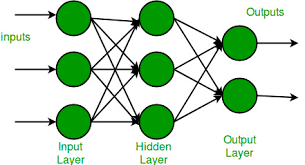

In [36]:
class ResNetBlock(nn.Module):

    '''
    1. in_channels: input channels tensor
    2. out_)channels: output channels tensor
    3. time_emb_dim: time embedding dimension
    4. dropout: prevents overfitting (model adjust too mucho to training data capturing noise)

    '''

    def __init__(self, in_channels: int, out_channels: int,
                 time_emb_dim: int, dropout: float = 0.0):
        super().__init__()

        # Proyección de time embedding al tamaño de los canales.
        # time embedding vector is transformed into a vector with same dimensions as the out_channels
        self.time_mlp = nn.Sequential(
            nn.SiLU(), #activation function
            nn.Linear(time_emb_dim, out_channels)
        )

        # Primer bloque convolucional
        self.block1 = nn.Sequential(
            nn.GroupNorm(8, in_channels), # Normalize. Stabilizes trainig
            nn.SiLU(), #activation function
            nn.Conv2d(in_channels, out_channels, 3, padding=1) # conv operation. a 3x3 filter takes an image with in_channels
                                                                # and produces out_channels
        )

        # Segundo bloque convolucional (con dropout)
        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        # Residual conection. RESNET important.
        # Block output is the sum of the previous block's outputs and the original input
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x:torch.Tensor, time_emb: torch.Tensor) -> torch.Tensor: # describe data flow through blocks
      '''

      x : Image tensor (batch_size , in_channels, H, W)
      time_emb : Time embedding (batch_size, time_emb_dim)

      '''

      h = self.block1(x)


      # Add time embedding

      time_emb = self.time_mlp(time_emb)[:, :, None, None]

      h = h + time_emb

      h = self.block2(h)

      return h + self.residual_conv(x) # F(x) + x is the residual function






Attention

MultiHead Attention. this is important because it gives wieght to different parts of the image, to produce a contextualized output.



In [37]:
class AttentionBlock(nn.Module):
    """
    Bloque de auto-atención para mejorar la coherencia global
    """

    def __init__(self, channels: int, num_heads: int = 4):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape

        h = self.norm(x)
        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=1)

        # Reshape para atención multi-head
        q = q.view(B, self.num_heads, C // self.num_heads, H * W).transpose(-1, -2)
        k = k.view(B, self.num_heads, C // self.num_heads, H * W).transpose(-1, -2)
        v = v.view(B, self.num_heads, C // self.num_heads, H * W).transpose(-1, -2)

        # Atención escalada
        scale = (C // self.num_heads) ** -0.5
        attn = torch.softmax(q @ k.transpose(-1, -2) * scale, dim=-1)
        h = (attn @ v).transpose(-1, -2).contiguous()
        h = h.view(B, C, H, W)

        return x + self.proj(h)

FLOW MATCHING CLASS UNET

unets are the one of the most important parts of any Nueral Network as it allows you to learn features .

Unet will learn to predict Marginal Vector Field



In [38]:
class FlowMatchingUNet(nn.Module):
    """
    U-Net modificada para Flow Matching que predice el campo vectorial marginal

    Esta red aprende a predecir v_θ(x_t, t) que aproxima el campo vectorial marginal
    """

    def __init__(
        self,
        in_channels: int = 3,
        model_channels: int = 128,
        num_res_blocks: int = 2,
        attention_resolutions: tuple = (16, 8),
        dropout: float = 0.0,
        channel_mult: tuple = (1, 2, 2, 2),
        num_heads: int = 4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads

        # Time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            TimeEmbedding(model_channels),
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Encoder
        self.input_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)

        ch = model_channels
        input_block_chans = [model_channels]
        self.input_blocks = nn.ModuleList()

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResNetBlock(ch, mult * model_channels, time_embed_dim, dropout)]
                ch = mult * model_channels

                # Agregar atención en resoluciones específicas
                if ch in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))

                self.input_blocks.append(nn.Sequential(*layers))
                input_block_chans.append(ch)

            # Downsampling (excepto en el último nivel)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(nn.Sequential(nn.Conv2d(ch, ch, 3, stride=2, padding=1)))
                input_block_chans.append(ch)

        # Middle
        self.middle_block = nn.Sequential(
            ResNetBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads),
            ResNetBlock(ch, ch, time_embed_dim, dropout),
        )

        # Decoder
        self.output_blocks = nn.ModuleList()
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResNetBlock(ch + ich, mult * model_channels, time_embed_dim, dropout)]
                ch = mult * model_channels

                if ch in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))

                # Upsampling en la última capa de cada nivel (excepto el primero)
                if level != 0 and i == num_res_blocks:
                    layers.append(nn.Upsample(scale_factor=2, mode='nearest'))

                self.output_blocks.append(nn.Sequential(*layers))

        # Output projection
        self.out = nn.Sequential(
            nn.GroupNorm(8, model_channels),
            nn.SiLU(),
            nn.Conv2d(model_channels, in_channels, 3, padding=1),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Predice el campo vectorial marginal v_θ(x_t, t)

        Args:
            x: Imágenes en tiempo t, forma (batch_size, C, H, W)
            t: Tiempo, forma (batch_size,) con valores en [0,1]

        Returns:
            Campo vectorial predicho de forma (batch_size, C, H, W)
        """
        # Time embedding
        t_emb = self.time_embed(t)

        # Encoder
        h = self.input_conv(x)
        hs = [h]

        for module in self.input_blocks:
            if isinstance(module[0], ResNetBlock):
                h = module[0](h, t_emb)
                if len(module) > 1:  # Si hay atención
                    h = module[1](h)
            else:  # Downsampling
                h = module(h)
            hs.append(h)

        # Middle
        h = self.middle_block[0](h, t_emb)  # ResNetBlock
        h = self.middle_block[1](h)         # AttentionBlock
        h = self.middle_block[2](h, t_emb)  # ResNetBlock

        # Decoder
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            if isinstance(module[0], ResNetBlock):
                h = module[0](h, t_emb)
                if len(module) > 1 and isinstance(module[1], AttentionBlock):
                    h = module[1](h)
                    if len(module) > 2:  # Upsampling
                        h = module[2](h)
                elif len(module) > 1:  # Solo upsampling
                    h = module[1](h)

        # Output
        return self.out(h)

# Inicializar el modelo
model = FlowMatchingUNet(
    in_channels=3,
    model_channels=64,  # Reducido para demo
    num_res_blocks=2,
    attention_resolutions=(16, 8),
    dropout=0.1,
    channel_mult=(1, 2, 2, 2),
    num_heads=4
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"=== Modelo FlowMatchingUNet ===")
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Tamaño del modelo: {total_params * 4 / 1024**2:.2f} MB")

# Prueba del modelo
def test_model():
    """Prueba el forward pass del modelo"""
    with torch.no_grad():
        # Crear datos de prueba
        batch_size = 4
        x_test = torch.randn(batch_size, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
        t_test = torch.rand(batch_size).to(device)

        # Forward pass
        output = model(x_test, t_test)

        print(f"\n=== Prueba del Modelo ===")
        print(f"Input shape: {x_test.shape}")
        print(f"Time shape: {t_test.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")

        # Verificar que la salida tiene la forma correcta
        assert output.shape == x_test.shape, f"Shape mismatch: {output.shape} vs {x_test.shape}"
        print("✓ Modelo funcionando correctamente")

test_model()

=== Modelo FlowMatchingUNet ===
Parámetros totales: 8,177,795
Parámetros entrenables: 8,177,795
Tamaño del modelo: 31.20 MB

=== Prueba del Modelo ===
Input shape: torch.Size([4, 3, 64, 64])
Time shape: torch.Size([4])
Output shape: torch.Size([4, 3, 64, 64])
Output range: [-1.161, 1.436]
✓ Modelo funcionando correctamente


=== Análisis de la Función de Pérdida ===
Pérdida MSE: 1.343805
Error por pixel: 0.926508
Magnitud target: 123.6902
Magnitud predicha: 37.5060
Cosine similarity: 0.0241
Tiempo promedio: 0.4859
Tiempo std: 0.2634


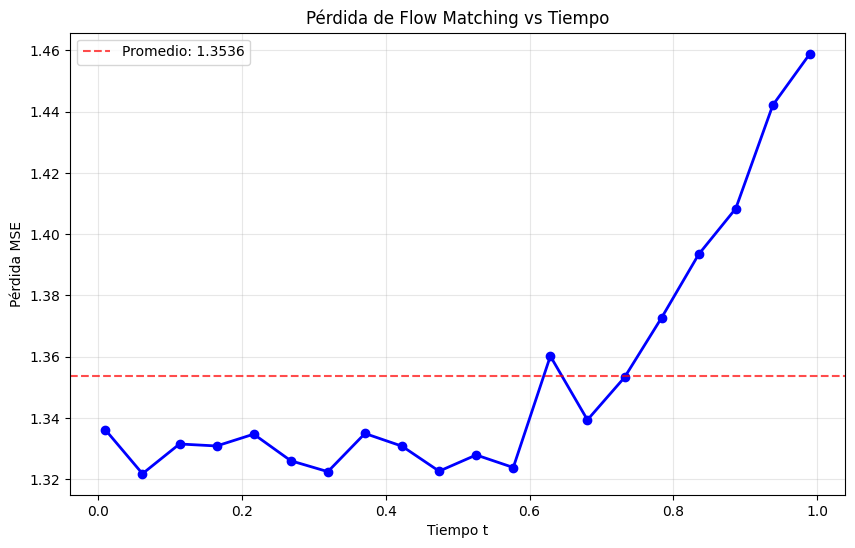

Pérdida mínima en t=0.06: 1.321784
Pérdida máxima en t=0.99: 1.458918


In [41]:
class FlowMatchingLoss(nn.Module):
    """
    Implementa la función de pérdida para Flow Matching

    La pérdida de Flow Matching es:
    L(θ) = E_{t,x_0,x_1}[||v_θ(x_t, t) - u_t(x_t|x_0,x_1)||²]

    donde:
    - x_0 ~ p_0 (distribución de ruido)
    - x_1 ~ p_1 (distribución de datos)
    - t ~ U[0,1] (tiempo uniforme)
    - x_t = (1-t)x_0 + t*x_1 (interpolación lineal)
    - u_t(x_t|x_0,x_1) = x_1 - x_0 (campo vectorial condicional)
    """

    def __init__(self, noise_source: GaussianNoiseSource):
        super().__init__()
        self.noise_source = noise_source

    def forward(
        self,
        model: nn.Module,
        x1: torch.Tensor,
        return_components: bool = False
    ) -> torch.Tensor:
        """
        Calcula la pérdida de Flow Matching

        Args:
            model: Modelo que predice el campo vectorial
            x1: Batch de datos reales (batch_size, C, H, W)
            return_components: Si True, retorna componentes individuales

        Returns:
            Pérdida escalar o diccionario con componentes
        """
        batch_size = x1.shape[0]
        device = x1.device

        # 1. Muestrear ruido x_0 ~ p_0(x)
        x0 = self.noise_source.sample(batch_size)

        # 2. Muestrear tiempo t ~ U[0,1]
        t = torch.rand(batch_size, device=device)

        # 3. Calcular punto interpolado x_t = (1-t)x_0 + t*x_1
        t_expanded = t.view(batch_size, 1, 1, 1)
        xt = (1 - t_expanded) * x0 + t_expanded * x1

        # 4. Calcular campo vectorial condicional (target)
        target_vf = create_condition_vector_field(x0, x1, t)

        # 5. Predecir campo vectorial con el modelo
        pred_vf = model(xt, t)

        # 6. Calcular pérdida MSE
        mse_loss = F.mse_loss(pred_vf, target_vf, reduction='mean')

        if return_components:
            # Calcular métricas adicionales
            with torch.no_grad():
                # Error por pixel promedio
                pixel_error = torch.mean(torch.abs(pred_vf - target_vf))

                # Magnitud promedio del campo vectorial objetivo
                target_magnitude = torch.mean(torch.norm(target_vf.view(batch_size, -1), dim=1))

                # Magnitud promedio del campo vectorial predicho
                pred_magnitude = torch.mean(torch.norm(pred_vf.view(batch_size, -1), dim=1))

                # Cosine similarity promedio
                pred_flat = pred_vf.view(batch_size, -1)
                target_flat = target_vf.view(batch_size, -1)
                cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=1).mean()

            return {
                'loss': mse_loss,
                'pixel_error': pixel_error,
                'target_magnitude': target_magnitude,
                'pred_magnitude': pred_magnitude,
                'cosine_similarity': cos_sim,
                'time_mean': t.mean(),
                'time_std': t.std()
            }

        return mse_loss

def analyze_loss_components():
    """
    Analiza los componentes de la pérdida de Flow Matching
    """
    loss_fn = FlowMatchingLoss(noise_source)

    # Obtener batch de datos
    real_batch = next(iter(train_loader)).to(device)

    with torch.no_grad():
        # Calcular componentes de la pérdida
        components = loss_fn(model, real_batch, return_components=True)

        print("=== Análisis de la Función de Pérdida ===")
        print(f"Pérdida MSE: {components['loss']:.6f}")
        print(f"Error por pixel: {components['pixel_error']:.6f}")
        print(f"Magnitud target: {components['target_magnitude']:.4f}")
        print(f"Magnitud predicha: {components['pred_magnitude']:.4f}")
        print(f"Cosine similarity: {components['cosine_similarity']:.4f}")
        print(f"Tiempo promedio: {components['time_mean']:.4f}")
        print(f"Tiempo std: {components['time_std']:.4f}")

def visualize_loss_landscape():
    """
    Visualiza el landscape de la pérdida en diferentes tiempos
    """
    loss_fn = FlowMatchingLoss(noise_source)

    # Obtener un batch pequeño
    real_batch = next(iter(train_loader))[:4].to(device)

    # Evaluar pérdida en diferentes tiempos
    time_points = torch.linspace(0.01, 0.99, 20)
    losses_by_time = []

    model.eval()
    with torch.no_grad():
        for t_val in time_points:
            # Fijar tiempo para todo el batch
            batch_size = real_batch.shape[0]
            t_fixed = torch.full((batch_size,), t_val, device=device)

            # Generar ruido
            x0 = noise_source.sample(batch_size)

            # Interpolación
            t_expanded = t_fixed.view(batch_size, 1, 1, 1)
            xt = (1 - t_expanded) * x0 + t_expanded * real_batch

            # Predicción y target
            target_vf = create_condition_vector_field(x0, real_batch, t_fixed)
            pred_vf = model(xt, t_fixed)

            # Pérdida
            loss = F.mse_loss(pred_vf, target_vf)
            losses_by_time.append(loss.item())

    model.train()

    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.plot(time_points.cpu().numpy(), losses_by_time, 'b-', linewidth=2, marker='o')
    plt.xlabel('Tiempo t')
    plt.ylabel('Pérdida MSE')
    plt.title('Pérdida de Flow Matching vs Tiempo')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=np.mean(losses_by_time), color='r', linestyle='--', alpha=0.7, label=f'Promedio: {np.mean(losses_by_time):.4f}')
    plt.legend()
    plt.show()

    print(f"Pérdida mínima en t={time_points[np.argmin(losses_by_time)]:.2f}: {min(losses_by_time):.6f}")
    print(f"Pérdida máxima en t={time_points[np.argmax(losses_by_time)]:.2f}: {max(losses_by_time):.6f}")

# Ejecutar análisis
analyze_loss_components()
visualize_loss_landscape()

In [42]:
class FlowMatchingTrainer:
    """
    Clase para entrenar el modelo de Flow Matching
    """

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        loss_fn: FlowMatchingLoss,
        lr: float = 1e-4,
        device: str = 'cuda',
        save_dir: str = 'checkpoints'
    ):
        self.model = model
        self.train_loader = train_loader
        self.loss_fn = loss_fn
        self.device = device
        self.save_dir = save_dir

        # Crear directorio de guardado
        os.makedirs(save_dir, exist_ok=True)

        # Optimizador y scheduler
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)

        # Historial de entrenamiento
        self.history = {
            'loss': [],
            'pixel_error': [],
            'cosine_similarity': [],
            'lr': []
        }

    def train_epoch(self, epoch: int) -> dict:
        """Entrena una época"""
        self.model.train()
        epoch_metrics = {
            'loss': 0.0,
            'pixel_error': 0.0,
            'cosine_similarity': 0.0,
            'count': 0
        }

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}')

        for batch_idx, batch in enumerate(pbar):
            batch = batch.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            components = self.loss_fn(self.model, batch, return_components=True)
            loss = components['loss']

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # Actualizar métricas
            epoch_metrics['loss'] += loss.item()
            epoch_metrics['pixel_error'] += components['pixel_error'].item()
            epoch_metrics['cosine_similarity'] += components['cosine_similarity'].item()
            epoch_metrics['count'] += 1

            # Actualizar barra de progreso
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'cos_sim': f"{components['cosine_similarity'].item():.3f}",
                'lr': f"{self.scheduler.get_last_lr()[0]:.2e}"
            })

        # Promediar métricas
        for key in epoch_metrics:
            if key != 'count':
                epoch_metrics[key] /= epoch_metrics['count']

        return epoch_metrics

    def validate_and_sample(self, num_samples: int = 16) -> torch.Tensor:
        """Genera muestras para validación"""
        self.model.eval()

        with torch.no_grad():
            # Generar ruido inicial
            x = noise_source.sample(num_samples)

            # Integración numérica de la ODE
            dt = 1.0 / 50  # 50 pasos

            for step in range(50):
                t = torch.full((num_samples,), step * dt, device=self.device)

                # Predecir campo vectorial
                vf = self.model(x, t)

                # Paso de Euler
                x = x + vf * dt

        self.model.train()
        return x

    def save_checkpoint(self, epoch: int, metrics: dict):
        """Guarda checkpoint del modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'metrics': metrics,
            'history': self.history
        }

        path = os.path.join(self.save_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save(checkpoint, path)
        print(f"Checkpoint guardado: {path}")

    def train(self, num_epochs: int, save_every: int = 10, sample_every: int = 5):
        """Entrenamiento principal"""
        print(f"=== Iniciando entrenamiento por {num_epochs} épocas ===")

        best_loss = float('inf')

        for epoch in range(num_epochs):
            # Entrenar época
            metrics = self.train_epoch(epoch)

            # Actualizar scheduler
            self.scheduler.step()

            # Guardar en historial
            self.history['loss'].append(metrics['loss'])
            self.history['pixel_error'].append(metrics['pixel_error'])
            self.history['cosine_similarity'].append(metrics['cosine_similarity'])
            self.history['lr'].append(self.scheduler.get_last_lr()[0])

            # Imprimir progreso
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"  Loss: {metrics['loss']:.6f}")
            print(f"  Pixel Error: {metrics['pixel_error']:.6f}")
            print(f"  Cosine Sim: {metrics['cosine_similarity']:.4f}")
            print(f"  LR: {self.scheduler.get_last_lr()[0]:.2e}")

            # Generar muestras periódicamente
            if (epoch + 1) % sample_every == 0:
                samples = self.validate_and_sample(16)
                self.visualize_samples(samples, epoch + 1)

            # Guardar checkpoint
            if (epoch + 1) % save_every == 0:
                self.save_checkpoint(epoch, metrics)

            # Guardar mejor modelo
            if metrics['loss'] < best_loss:
                best_loss = metrics['loss']
                best_path = os.path.join(self.save_dir, 'best_model.pt')
                torch.save(self.model.state_dict(), best_path)

        print("=== Entrenamiento completado ===")

    def visualize_samples(self, samples: torch.Tensor, epoch: int):
        """Visualiza muestras generadas"""
        # Desnormalizar
        samples = (samples + 1) / 2
        samples = torch.clamp(samples, 0, 1)

        # Crear grid
        grid = make_grid(samples, nrow=4, padding=2)

        plt.figure(figsize=(10, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'Muestras Generadas - Época {epoch}')
        plt.axis('off')
        plt.tight_layout()

        # Guardar imagen
        save_path = os.path.join(self.save_dir, f'samples_epoch_{epoch}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

    def plot_training_history(self):
        """Visualiza el historial de entrenamiento"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Pérdida
        axes[0, 0].plot(self.history['loss'], 'b-', linewidth=2)
        axes[0, 0].set_title('Pérdida de Entrenamiento')
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].set_ylabel('Pérdida MSE')
        axes[0, 0].grid(True, alpha=0.3)

        # Error por pixel
        axes[0, 1].plot(self.history['pixel_error'], 'g-', linewidth=2)
        axes[0, 1].set_title('Error por Pixel')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].set_ylabel('Error L1')
        axes[0, 1].grid(True, alpha=0.3)

        # Cosine similarity
        axes[1, 0].plot(self.history['cosine_similarity'], 'r-', linewidth=2)
        axes[1, 0].set_title('Similitud Coseno')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Cosine Similarity')
        axes[1, 0].grid(True, alpha=0.3)

        # Learning rate
        axes[1, 1].plot(self.history['lr'], 'purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('LR')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Inicializar trainer
loss_fn = FlowMatchingLoss(noise_source)
trainer = FlowMatchingTrainer(
    model=model,
    train_loader=train_loader,
    loss_fn=loss_fn,
    lr=2e-4,
    device=device,
    save_dir='flow_matching_checkpoints'
)

# Entrenar modelo (usar pocas épocas para demo)
print("Iniciando entrenamiento de demostración...")
trainer.train(num_epochs=20, save_every=10, sample_every=5)

# Visualizar historial
trainer.plot_training_history()

Iniciando entrenamiento de demostración...
=== Iniciando entrenamiento por 20 épocas ===


Epoch 1:   2%|▏         | 4/245 [00:13<13:38,  3.39s/it, loss=0.9338, cos_sim=0.510, lr=2.00e-04]


KeyboardInterrupt: 